# Time Series Anomaly Detection

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

<hr style="border:2px solid black"> </hr>

## Moving Averages
- **Rolling AKA SME (simple moving average):**
    - extreme on one side (opposite of expanding window)
    - any TS data, information at a particular point is heavily influenced by data around it
        - ex: stock prices are influenced by stock prices in last 7 days
    - might have missing data
        - 7 day rolling average, first 6 days will have missing data
        
        <br>
        
- **Expanding Window AKA cumulative moving average**: 
    - extreme on one side (opposite of rolling)
    - takes average, but window gets bigger and bigger over time
    - all data prior to that point
    - at any point, the value is the mean of ALL the values before it
    - useful for static process
        - ex: polling averages- start using polls a year before the election to see who will win. most people are already decided
    
    <br>
    
- **Exponential Moving Average**:
    - middle ground
    - look at last 'X # of days' but you will put more weight on the more recent values 
        - ex: more value on yesterday than last week


Exponential reacts faster to change

<hr style="border:1px solid black"> </hr>

## Bollinger Bands
- Volatility indicator
- Commonly used:
    - financial market
    - stock market trading
- relative defination of high and low prices of a market

<br>

#### Steps:
- **1st**: draw a moving average (.rolling)
    - this is called midband
    - midband = train.ewm(span=30).mean()
- **2nd**: draw lower band (using std)
    - midband +/- stdev * K
    - stdev = train.ewm(span=30).std()
    - K= numer of std deviations from EWM
- **3rd**: draw upper band (using std)
    - midband +/- stdev * K
    - stdev = train.ewm(span=30).std()
    - K= numer of std deviations from EWM

<br>

- movement beyond the 'bands' would be an anomaly

<br>

- Stock Trading Example:
    - when price is touching (or below) lower band, you buy the stock
    - when price hits midband, you sell the stock
    - **OR** if wanting high profit (high risk), wait until the price hits (or goes above) upperband 

- pct_b:
    - shows where the last value sits in relation to the bands
        - %b = (last-b)/(ub-lb)
        - %b >1 => point lies above UB
        - %b <0 => pint lies below LB
        - %b == 0.5 => poin lies on the midband

<hr style="border:3px solid black"> </hr>

In [2]:
#create names for columns
colnames = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']

#read in csv to pandas df
#seperator is spaces
df = pd.read_csv("anonymized-curriculum-access-07-2021.txt", 
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 2, 3, 4, 5])
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


## Prepare

In [3]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

In [4]:
# resample daily counts for number of page views

pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

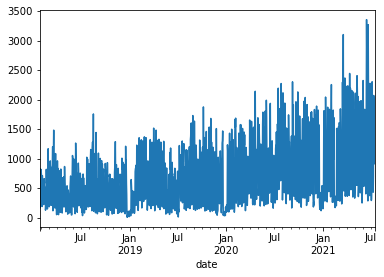

In [5]:
#plot pages
pages.plot()

In [6]:
## EMA

<AxesSubplot:xlabel='date'>

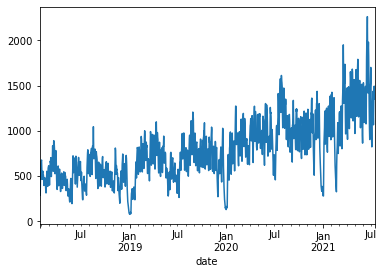

In [7]:
# 7 day EMA
ema_7d = pages.ewm(span = 7).mean()
ema_7d.plot()

<AxesSubplot:xlabel='date'>

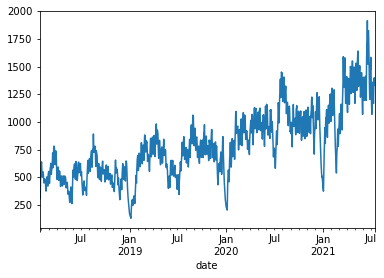

In [8]:
# 14 days EMA
ema_14d = pages.ewm(span = 14).mean()
ema_14d.plot()

<AxesSubplot:xlabel='date'>

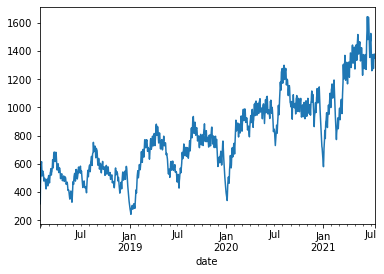

In [9]:
# 30 days EMA
ema_30d =pages.ewm(span = 30).mean()
ema_30d.plot()

<AxesSubplot:xlabel='date'>

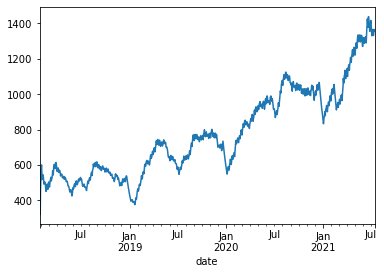

In [10]:
# 90 days EMA
ema_90d =pages.ewm(span = 90).mean()
ema_90d.plot()

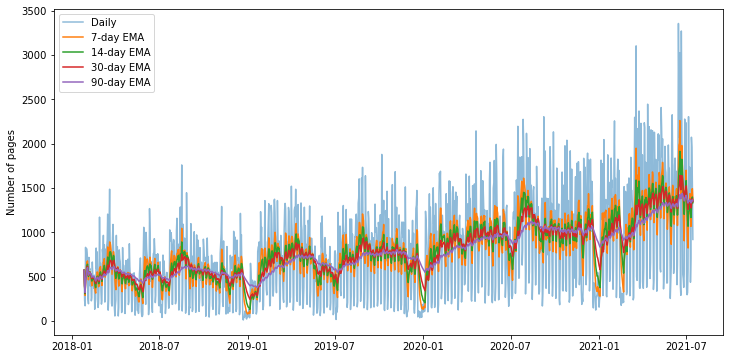

In [11]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

## Calculate Bollinger Bands

In [12]:
#calculate midband
span = 30

midband= pages.ewm(span=30).mean()
midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [13]:
std = pages.ewm(span=30).std()

In [14]:
#calculate upper and lower using 3std
ub = midband+ std * 3
lb = midband- std *3
ub.head()

date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
Freq: D, Name: endpoint, dtype: float64

In [15]:
#concat pages, midband, lb and ub
my_df =pd.concat([pages, midband, ub, lb], axis=1)
my_df.columns= ['pages', 'midband', 'ub','lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


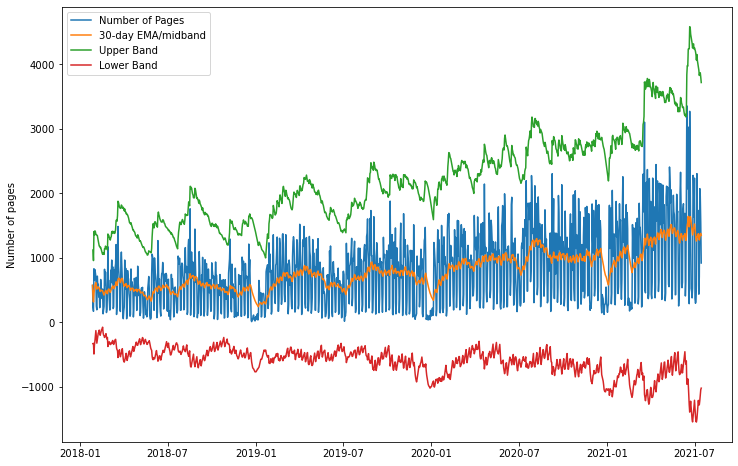

In [16]:
#plot bollinger bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [17]:
my_df['pct_b'] = (my_df['pages']- my_df['lb']/ (my_df['ub']- my_df['lb']))
                  
my_df.head()                  

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,230.227564
2018-01-28,170,315.139578,956.773991,-326.494835,170.254424
2018-01-29,830,457.002386,1406.405897,-492.401124,830.259321
2018-01-30,652,501.369064,1354.808245,-352.070116,652.206265


In [18]:
my_df[my_df.pct_b > 1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-27,230,395.300000,1120.791557,-330.191557,230.227564
2018-01-28,170,315.139578,956.773991,-326.494835,170.254424
2018-01-29,830,457.002386,1406.405897,-492.401124,830.259321
2018-01-30,652,501.369064,1354.808245,-352.070116,652.206265
2018-01-31,816,562.921651,1418.090581,-292.247280,816.170871
...,...,...,...,...,...
2021-07-11,708,1274.669395,3828.085288,-1278.746498,708.250399
2021-07-12,2073,1326.174596,3867.319606,-1214.970415,2073.239060
2021-07-13,1956,1366.808493,3869.549128,-1135.932143,1956.226938


## put it all together

In [19]:
def acquire(file_name, column_names):
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev * weight
    lb = midband - stdev * weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
#     plt_bands(my_df, user)
    return my_df[my_df.pct_b > 1]

In [20]:
#acquire
file_name = "anonymized-curriculum-access-07-2021.txt"
column_names = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = acquire(file_name, column_names)
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [21]:
user = 341
span = 30
weight = 3

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

In [26]:
anomalies.head()

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2020-02-18,3,0.193548,2.817185,-2.430088,1.034840,341
2020-04-21,109,7.250725,102.413277,-87.911826,1.034608,341
2021-02-09,10,0.659630,9.508602,-8.189342,1.027766,341
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341


In [22]:
#30 days
span = 30
#chose whatever weight you feel is appropriate
weight = 3.5

# loop through all the users
anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, user, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [23]:
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2020-02-18,3,0.193548,2.817185,-2.430088,1.034840,341
2020-04-21,109,7.250725,102.413277,-87.911826,1.034608,341
2021-02-09,10,0.659630,9.508602,-8.189342,1.027766,341
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
...,...,...,...,...,...,...
2021-02-09,10,0.659630,9.508602,-8.189342,1.027766,341
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2020-02-18,3,0.193548,2.817185,-2.430088,1.034840,341


In [24]:
anomalies.pages.value_counts(sort =False)

272    1082
109    1082
10     1082
3      1082
Name: pages, dtype: int64

In [25]:
anomalies[anomalies.pages == 343]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
